In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#Loading the dataset
dataset = pd.read_csv("dataset(clean).csv")
#number of sameples in dataset
len(dataset)

916575

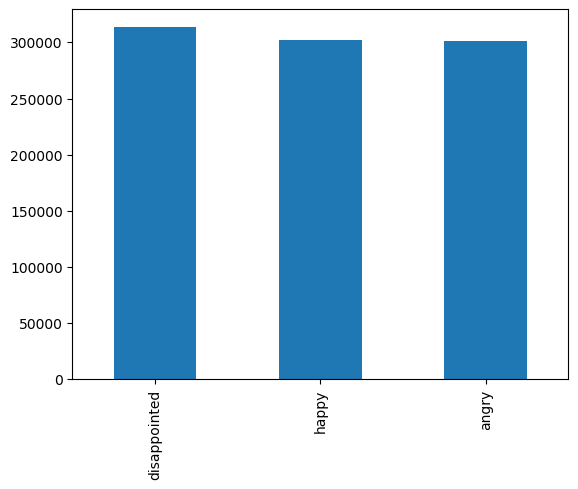

In [88]:
dataset.Emotion.value_counts().plot.bar()

In [89]:
input_sentences = [text.split(" ") for text in dataset["Content"].values.tolist()]
labels = dataset["Emotion"].values.tolist()

In [90]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)

    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
print(label2id)
print(len(word2id))

{'happy': 0, 'disappointed': 1, 'angry': 2}
168965


In [91]:
import keras
from sklearn.model_selection import train_test_split
# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]
# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# Print shapes
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (733260, 178)
Shape of Y_train: (733260, 3)
Shape of X_test: (183315, 178)
Shape of Y_test: (183315, 3)


In [92]:
from tensorflow import keras
model = keras.models.load_model('model.07-0.22.h5')

In [93]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

In [117]:
import random
import math,string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Select random samples to illustrate
sample_text = "Thanks you"
# Lower text
lower_samples=sample_text.lower()
print(lower_samples)
#change emoji into text
lower_samples = emoji.demojize(lower_samples)
print(lower_samples)

# Tokenize samples
tokenized_sample=word_tokenize(lower_samples)
print("tokenized_sample",tokenized_sample)


# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
removedpunctuation = [w.translate(table) for w in tokenized_sample]
print(removedpunctuation)

# remove remaining tokens that are not alphabetic
strippedwords = [word for word in removedpunctuation if word.isalpha()]
print(strippedwords)
        
finaltext=" ".join(removedpunctuation)
print(finaltext)



thanks you
thanks you
tokenized_sample ['thanks', 'you']
['thanks', 'you']
['thanks', 'you']
thanks you


In [118]:
#encode the samples
tokenized_sample = finaltext.split(" ")
print(tokenized_sample)
encoded_samples = [[word2id[word] for word in strippedwords]]
print(encoded_samples)


['thanks', 'you']
[[2347, 176]]


{'happy': 0.30783102, 'disappointed': 0.24269561, 'angry': 0.44947332}


[0.30783102, 0.24269561, 0.44947332]


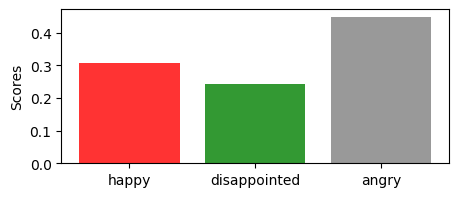

In [119]:
# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)

label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}
print(label_probs)

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
print(scores)
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.8, color=['red', 'green', 'grey'])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()


In [104]:
results = model.evaluate(X_test, Y_test, batch_size=64)
print('test loss, test acc:', results)

2865/2865 [==============================] - 40s 14ms/step - loss: 0.1468 - accuracy: 0.9387
test loss, test acc: [0.14677633345127106, 0.9387065768241882]
